In [1]:
import math
import time
from pickletools import uint8
import cv2 
import matplotlib.pyplot as plt
import numpy as np
from skimage import morphology
import matplotlib.ticker as ticker
from collections import deque
import skimage.transform as st
import statistics as stat
import json
from IPython.display import clear_output
from skimage import morphology
from skimage.measure import profile_line
from turtle import color
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp

In [2]:
label_path = "04_plt.png"
label = cv2.imread(label_path)
label = cv2.cvtColor(label, cv2.COLOR_BGR2GRAY)


img_original_path = '04_test.png'
img_original= cv2.imread(img_original_path)
img_raw = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)
img_raw_gray = cv2.cvtColor(img_raw,cv2.COLOR_RGB2GRAY)


In [3]:
hh,ww=img_raw_gray.shape

label=cv2.resize(label,(ww,hh), interpolation =cv2.INTER_NEAREST)

In [4]:

blr_img=cv2.blur(label,(2,2))
#threshold for binary mask
label=np.where((blr_img > 110),1.,0.)
skel_original, distance =morphology.medial_axis(label, return_distance=True)
h,w = skel_original.shape
skel_original = np.array(skel_original)
# convert the skel array from boolean to number
skel_original =skel_original*1.0

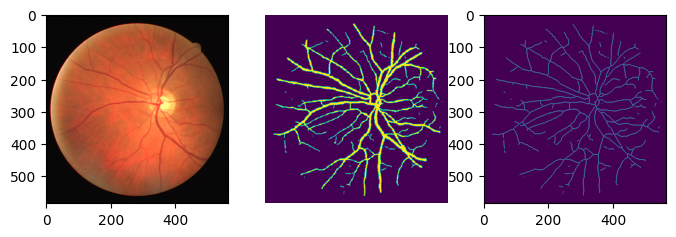

In [5]:
plt.figure(figsize=(8,8))
plt.subplot(1,3,1)
plt.imshow(img_raw)
plt.axis()
plt.subplot(1,3,2)
plt.imshow(label)
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(skel_original)


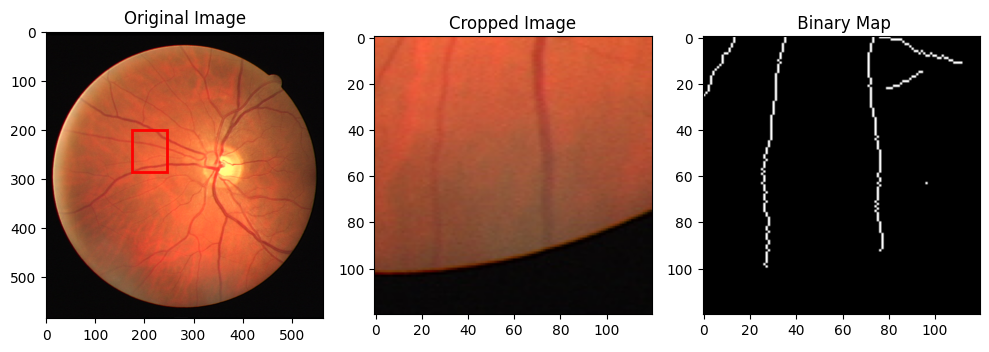

In [6]:
import matplotlib.patches as patches

raw = img_raw#[150:240,150:195]#[205:250,200:285]#[280:350,100:200]

# Create a figure and axis
plt.figure(figsize=(10, 4))

plt.subplot(1, 3, 1)
plt.imshow(img_raw)
plt.title("Original Image")

# Add a rectangle around the specified range
rect = patches.Rectangle((175,200), 70, 85, linewidth=2, edgecolor='r', facecolor='none')
plt.gca().add_patch(rect)
raw= img_raw[460:580,280:400] #[150:240,150:195]
# Second subplot 
plt.subplot(1, 3, 2)
plt.imshow(raw)
plt.title("Cropped Image")

# Third subplot 
plt.subplot(1, 3, 3)
skel= skel_original[460:580,280:400] 
#[150:240,150:195]
plt.imshow(skel, cmap= 'grey')
plt.title(" Binary Map")

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


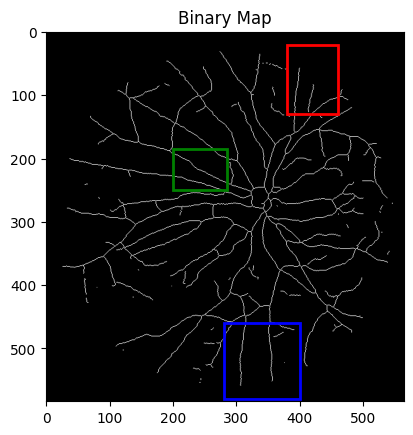

In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Define the coordinates for the three regions
region1 = [slice(20, 130), slice(380, 460)]  # Region 1
region2 = [slice(185, 250), slice(200, 285)]  # Region 2
region3 = [slice(460, 580), slice(280, 400)]  # Region 3

# Plot the original image
plt.imshow(skel_original, cmap='gray')
plt.title("Binary Map")

# Add rectangles for each region
rect1 = patches.Rectangle((region1[1].start, region1[0].start), 
                          region1[1].stop - region1[1].start, 
                          region1[0].stop - region1[0].start, 
                          linewidth=2, edgecolor='r', facecolor='none')
plt.gca().add_patch(rect1)

rect2 = patches.Rectangle((region2[1].start, region2[0].start), 
                          region2[1].stop - region2[1].start, 
                          region2[0].stop - region2[0].start, 
                          linewidth=2, edgecolor='g', facecolor='none')
plt.gca().add_patch(rect2)

rect3 = patches.Rectangle((region3[1].start, region3[0].start), 
                          region3[1].stop - region3[1].start, 
                          region3[0].stop - region3[0].start, 
                          linewidth=2, edgecolor='b', facecolor='none')
plt.gca().add_patch(rect3)

plt.show()


Tracking of Pixels, Looking for neighbours of Pixels

In [8]:

# Get coordinates of true pixels
true_pixel_coordinates = np.column_stack(np.where(skel > 0))

# Function to check if two coordinates are neighbors (including diagonals)
def are_neighbors(coord1, coord2):
    return abs(coord1[0] - coord2[0]) <= 1 and abs(coord1[1] - coord2[1]) <= 1

# Start the list with the first coordinate
vessels = {0: [tuple(true_pixel_coordinates[0])]}  # Vessels are stored

# Iterate through true pixel coordinates
for coord in true_pixel_coordinates[1:]:
    assigned_to_vessel = False
    for vessel_id, vessel in vessels.items():
        # Check if the coordinate is a neighbor of any existing vessel, means no already used coordinates are reused,prevents infinite loop
        if any(are_neighbors(vessel_coord, coord) for vessel_coord in vessel):
            vessels[vessel_id].append(tuple(coord))
            assigned_to_vessel = True
            break
    
    # If not assigned to any existing vessel and not a neighbour, create a new vessel
    if not assigned_to_vessel:
        vessels[len(vessels)] = [tuple(coord)]

# Combine coordinates of all vessels
all_vessels_coords = [coord for vessel in vessels.values() for coord in vessel]

# variable for all tracked vessels
all_vessels_image = np.zeros_like(skel) #same data type and shape as skel but all zeroes

# Set pixels in all vessels to 1
for coord in all_vessels_coords:
    all_vessels_image[coord[0], coord[1]] = 1

Tracking off Vessels, Looking for neighbours in Vessels

In [64]:
# Function to check if two vessels have neighboring coordinates (including diagonals)
def have_neighbors(vessel1, vessel2):
    for coord1 in vessel1:
        for coord2 in vessel2:
            if abs(coord1[0] - coord2[0]) <= 1 and abs(coord1[1] - coord2[1]) <= 1:
                return True
    return False

# Combine vessels with neighboring coordinates
combined_vessels = {}

for vessel_id, vessel in vessels.items():
    merged = False
    for combined_id, combined_vessel in combined_vessels.items():
        if have_neighbors(vessel, combined_vessel):
            combined_vessels[combined_id] += vessel
            merged = True
            break

    if not merged:
        combined_vessels[len(combined_vessels)] = vessel

# Filter out small vessels (<2)
filtered_combined_vessels = {vessel_id: vessel for vessel_id, vessel in combined_vessels.items() if len(vessel) >= 0}

# Visualize combined vessels
combined_vessels_image = np.zeros_like(skel)

# Set pixels in combined vessels to 1
for vessel_id, vessel in filtered_combined_vessels.items():
    for coord in vessel:
        combined_vessels_image[coord[0], coord[1]] = 1


In [65]:
# Calculate and print the total number of vessels
total_vessels = len(combined_vessels)
print(f"Total number of vessels: {total_vessels}")

Total number of vessels: 6


Take Vessels from Tracking and Remove those with less than 6 coordinates/Pixels

In [63]:
# Get the original number of vessels
original_num_vessels = len(combined_vessels)

# Filter out vessels with less than 6 pixels
filtered_renamed_combined_vessels = {new_id: vessel for new_id, (old_id, vessel) in enumerate(combined_vessels.items()) if len(vessel) >= 50}

# Get the new number of vessels after filtering
filtered_num_vessels = len(filtered_renamed_combined_vessels)

# Determine how many vessels were removed
removed_vessels = original_num_vessels 
# Renumber the vessel IDs from [0] to [N]
renamed_combined_vessels = {new_id: vessel for new_id ,(old_id, vessel) in enumerate(filtered_renamed_combined_vessels.items())}

for vessel_id, vessel in renamed_combined_vessels.items():
    print(f"Vessel {vessel_id}: Size = {len(vessel)}")

# Count the total number of coordinates
total_coordinates = sum(len(vessel) for vessel in renamed_combined_vessels.values())



# Print the total number of coordinates
print(f"Total Number of Coordinates: {total_coordinates}")



Vessel 0: Size = 100
Vessel 1: Size = 93
Vessel 2: Size = 54
Total Number of Coordinates: 247


Getting Largest vessels Variables for plotting

In [12]:
# Visualize all final combined vessels
all_combined_vessels_image = np.zeros_like(skel)

# Set pixels in all final combined vessels to 1
for vessel_id, vessel in renamed_combined_vessels.items():
    for coord in vessel:
        all_combined_vessels_image[coord[0], coord[1]] = 1



# Get the coordinates of Vessel 0 (Largest VESSEL)
vessel0_coords = renamed_combined_vessels[0]  # Change this to the index of the vessel to visualize

# Visualize Vessel 0
vessel0_image = np.zeros_like(skel)

# Set pixels in Vessel 0 to 1
for coord in vessel0_coords:
    vessel0_image[coord[0], coord[1]] = 1

# Extracting all coordinates from the renamed_combined_vessels dictionary
    all_coordinates = [coord for vessel in renamed_combined_vessels.values() for coord in vessel]



In [13]:
# Initialize an empty list to store all coordinates
all_coordinates = []

# Iterate over each vessel
for vessel_id, vessel_coords in renamed_combined_vessels.items():
    # Create a binary image for the current vessel
    vessel_image = np.zeros_like(skel)
    for coord in vessel_coords:
        vessel_image[coord[0], coord[1]] = 1
        all_coordinates.append(coord)  # Append the coordinate to the list

    # Add the current vessel to the overall visualization
    all_combined_vessels_image += vessel_image



C:\Users\Jessi\AppData\Local\Temp\ipykernel_23488\1734703131.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(renamed_combined_vessels) + 1)


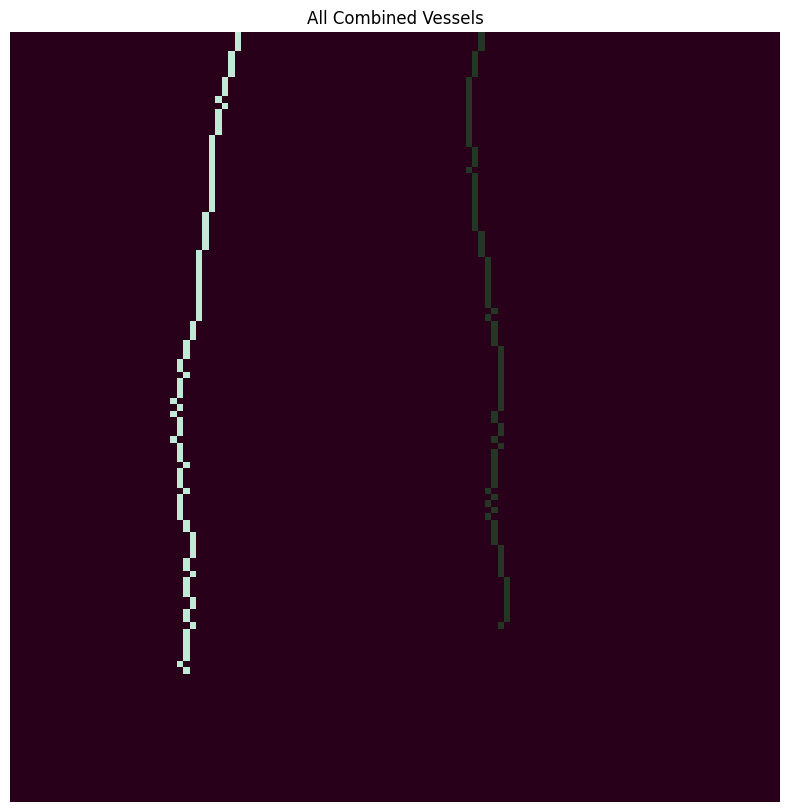

In [68]:
# Visualize all final combined vessels on a black background
all_combined_vessels_image_2 = np.zeros_like(skel)

# Set pixels in all final combined vessels to vessel IDs
for vessel_id, vessel in renamed_combined_vessels.items():
    for coord in vessel:
        all_combined_vessels_image_2[coord[0], coord[1]] = vessel_id

# Create a color map with a different color for each vessel
colors = plt.cm.get_cmap('tab10', len(renamed_combined_vessels) + 1)

# Plot the all_combined_vessels_image on a black background with different colors fo`r each vessel
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(all_combined_vessels_image,vmin=0, vmax=len(renamed_combined_vessels))

# Overlay vessel0 in pink
vessel0_coords = renamed_combined_vessels[0]
vessel0_image = np.zeros_like(skel)
for coord in vessel0_coords:
    vessel0_image[coord[0], coord[1]] = 1
ax.imshow(vessel0_image, cmap='pink', vmin=0, vmax=1, alpha=0.7) 

ax.set_title('All Combined Vessels')
ax.set_axis_off()
plt.show()



Plotting Final Images

C:\Users\Jessi\AppData\Local\Temp\ipykernel_23488\4164627384.py:17: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  axes[2].imshow(skel[40:140,300:400], cmap='gray')  # Display only the specified range


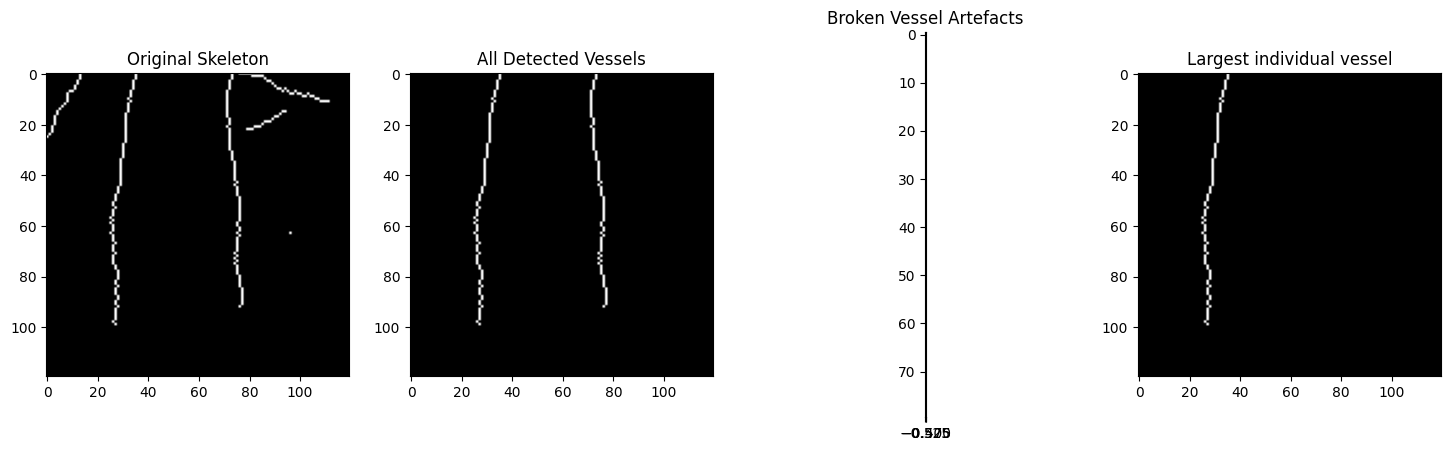

In [69]:
# Plotting
fig, axes = plt.subplots(1, 4, figsize=(18, 5))

# Plot original skel
axes[0].imshow(skel, cmap='gray')
axes[0].set_title('Original Skeleton')

# Plot all final combined vessels
axes[1].imshow(all_combined_vessels_image, cmap='gray')
axes[1].set_title('All Detected Vessels')
rect0 = patches.Rectangle((300,40), 100, 100, linewidth=2, edgecolor='red', facecolor='none')
axes[1].add_patch(rect0)
# Plot Vessel 0
axes[2].imshow(combined_vessels_image, cmap='gray')
axes[2].set_title('All Detected Vessels > 6 Coordinates')
# Plot small section for showing noise
axes[2].imshow(skel[40:140,300:400], cmap='gray')  # Display only the specified range
axes[2].set_title('Broken Vessel Artefacts')           # if thie third plot is empty its because the small zoom in range is outwith the small image range your looking at, can change this at the very start where you define the region

# Plot largest individual
axes[3].imshow(vessel0_image, cmap='gray')
axes[3].set_title('Largest individual vessel')

plt.show()


In [16]:
num_ones = np.sum(vessel0_image == 1)

print("Number of binary 1 valued coordinates:", num_ones)


Number of binary 1 valued coordinates: 100


For checking accuracy

In [18]:

# Get coordinates of true pixels in each image
true_coords_original = np.column_stack(np.where(skel > 0))
true_coords_all_combined_vessels = np.column_stack(np.where(all_combined_vessels_image > 0))
true_coords_combined_vessels_gt_6 = np.column_stack(np.where(combined_vessels_image > 0))
true_coords_largest_vessel = np.column_stack(np.where(vessel0_image > 0))

# Count the number of true coordinates in each image
num_true_coords_original = len(true_coords_original)
num_true_coords_all_combined_vessels = len(true_coords_all_combined_vessels)
num_true_coords_combined_vessels_gt_6 = len(true_coords_combined_vessels_gt_6)
num_true_coords_largest_vessel = len(true_coords_largest_vessel)

# Print the results
print(f"Number of true coordinates in the original skeleton image: {num_true_coords_original}") #with noise
print(f"Number of true coordinates in all combined vessels image: {num_true_coords_all_combined_vessels}") # removed small vessels below 6 coordinates
print(f"Number of true coordinates in vessels with more than 6 coordinates: {num_true_coords_combined_vessels_gt_6}")
print(f"Number of true coordinates in the largest individual vessel image: {num_true_coords_largest_vessel}")


Number of true coordinates in the original skeleton image: 273
Number of true coordinates in all combined vessels image: 193
Number of true coordinates in vessels with more than 6 coordinates: 273
Number of true coordinates in the largest individual vessel image: 100


# Characterisation


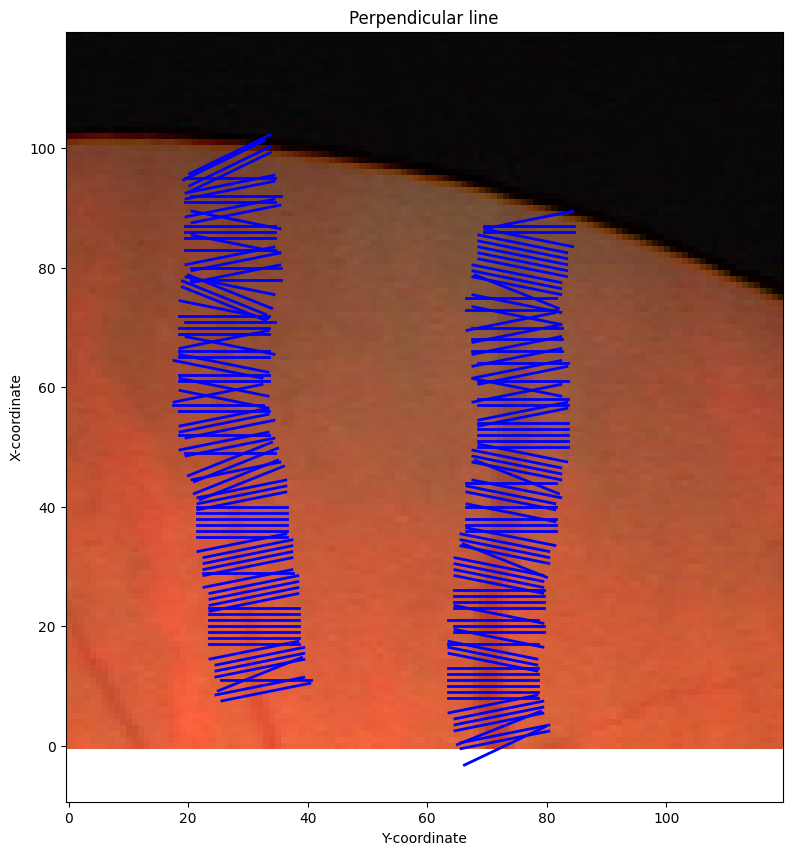

Perpendicular Line Start Coordinates: [array([ 7.52912899, 25.64564493]), array([ 8.52912899, 24.64564493]), array([11. , 25.5]), array([ 9.21456993, 25.03642482]), array([11.52912899, 24.64564493]), array([12.52912899, 24.64564493]), array([13.52912899, 24.64564493]), array([14.52912899, 23.64564493]), array([17. , 23.5]), array([18. , 23.5]), array([19. , 23.5]), array([20. , 23.5]), array([21. , 23.5]), array([22. , 23.5]), array([23. , 23.5]), array([22.52912899, 23.64564493]), array([23.52912899, 23.64564493]), array([24.52912899, 23.64564493]), array([25.52912899, 23.64564493]), array([26.52912899, 22.64564493]), array([29. , 22.5]), array([28.52912899, 22.64564493]), array([29.52912899, 22.64564493]), array([30.52912899, 22.64564493]), array([31.52912899, 22.64564493]), array([32.52912899, 21.64564493]), array([35. , 21.5]), array([36. , 21.5]), array([37. , 21.5]), array([38. , 21.5]), array([39. , 21.5]), array([40. , 21.5]), array([39.52912899, 21.64564493]), array([40.529128

In [19]:
subset_coords = all_coordinates     #renamed_combined_vessels[0] + renamed_combined_vessels[1]#+ renamed_combined_vessels[2]    #either use all coords or can pick individual vessels
def calculate_direction(coords):
    # Calculate the average direction based on the given points
    direction_sum = np.array([0.0, 0.0])
    num_points = len(coords) - 1

    for i in range(num_points):
        direction_sum += np.array(coords[i + 1]) - np.array(coords[i])

    direction = direction_sum / num_points
    norm = np.linalg.norm(direction)

    return direction / norm if norm != 0 else np.array([np.nan, np.nan])


def calculate_perpendicular(direction):
    return np.array([-direction[1], direction[0]])


fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(raw, cmap='gray')
ax.set_title('Perpendicular line')

line_start_list = []
line_end_list = []
vessel_points_list = []

for i in range(8, len(subset_coords) - 5, 1):
    candidate_points = [subset_coords[i], subset_coords[i + 1], subset_coords[i + 2],
                        subset_coords[i + 3], subset_coords[i + 4], subset_coords[i + 5]]

    middle_point = candidate_points[1]

    direction = calculate_direction(candidate_points)

    perpendicular = calculate_perpendicular(direction)

    line_start = middle_point - 7.5 * perpendicular
    line_end = middle_point + 7.5 * perpendicular

    line_start_list.append(line_start)
    line_end_list.append(line_end)

    vessel_points_list.append(middle_point)

    ax.plot([line_start[1], line_end[1]], [line_start[0], line_end[0]], color='b', linestyle='-', linewidth=2)

ax.set_xlabel('Y-coordinate')
ax.set_ylabel('X-coordinate')
plt.gca().invert_yaxis()
plt.show()

print("Perpendicular Line Start Coordinates:", line_start_list)
print("Perpendicular Line End Coordinates:", line_end_list)
print("Vessel Middle Points List:", vessel_points_list) #middle point (where vessel lies)

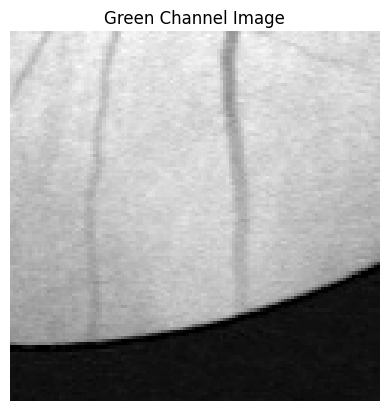

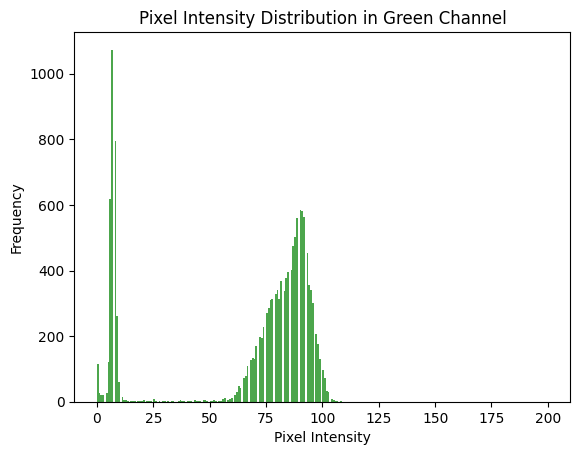

In [70]:
# Extract the green channel from the image
green_channel = raw[:, :, 1]  
# Plot the green channel image
plt.imshow(green_channel, cmap='gray')  
plt.title('Green Channel Image')
plt.axis('off')  
plt.show()
# Flatten the 2D array to 1D
green_values = green_channel.flatten()

# Plot histogram
plt.hist(green_values, bins=256,range= (0,200), color='green', alpha=0.7)
plt.title('Pixel Intensity Distribution in Green Channel')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()


Gaussian Fitting in the green channel

In [24]:
# Initialize lists to store data
num_pairs = len(line_start_list)
amp_val_a_g = []
start_coords_list_a_g = []
end_coords_list_a_g = []
vessel_points_a_g = []  
width_g = []
r_squared_values_g = []

# Loop over each pair of coordinates
for i in range(num_pairs):
    start_coord = line_start_list[i]
    end_coord = line_end_list[i]

    # Create a copy of the original image
    raw_copy_1 = raw.copy()

    # Profile line for the current pair of coordinates on the green channel
    green_channel = raw_copy_1[:, :, 1] 
    pl = profile_line(green_channel, start_coord, end_coord, order=2, mode='constant', linewidth=1)

    # Plot the original profile line
    x_values = np.arange(len(pl))

    # Define the Gaussian model
    def gaussian(x, a, b, c, d, e):
        gs = np.exp(-((x - b)**2) / (2 * c**2))
        linearfunc = (d * x) + e
        return a * gs + linearfunc

    # Initial guess for Gaussian model parameters
    p0 = [np.mean(pl), np.mean(x_values), 1, 1, 0]

    # Fit Gaussian model
    try:
        coeff, covariance = curve_fit(gaussian, x_values, pl, p0=p0, maxfev=1000000)

        # Calculate R-squared value
        residuals = pl - gaussian(x_values, *coeff)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((pl - np.mean(pl))**2)
        r_squared = 1 - (ss_res / ss_tot)

        # Save the R-squared value
        r_squared_values_g.append(r_squared)

        # Check R-squared value, width condition, and amp value condition, then save data to the new lists
        if 0 <= np.abs(coeff[2]) <= 15 and r_squared > 0.10:  #setting restrictions on r and width 
            amp_val_a_g.append(np.abs(coeff[0]))
            width_g.append(np.abs(coeff[2]))
            start_coords_list_a_g.append(start_coord)
            end_coords_list_a_g.append(end_coord)
            vessel_points_a_g.append(vessel_points_list)

    except Exception as e:
        print(f"Error occurred for pair {i}: {e}")


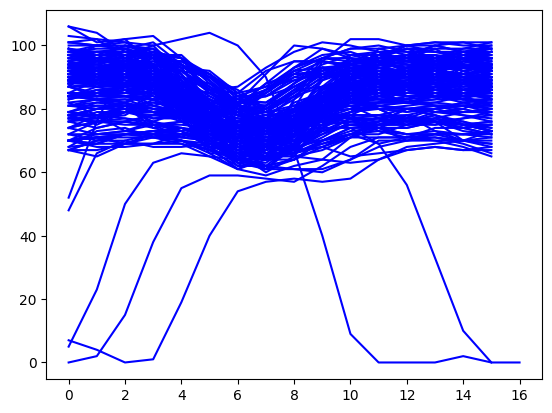

In [25]:
# Loop over each pair of coordinates
for i in range(num_pairs):
    start_coord = line_start_list[i]
    end_coord = line_end_list[i]

    # Create a copy of the original image
    raw_copy_1 = raw.copy()

    # Profile line for the current pair of coordinates on the green channel
    green_channel = raw_copy_1[:, :, 1]  
    pl = profile_line(green_channel, start_coord, end_coord, order=2, mode='constant', linewidth=1)

    # Plot the original profile line
    x_values = np.arange(len(pl))
    plt.plot(x_values, pl, color='blue', label='Profile Line')

    # Define the Gaussian model
    def gaussian(x, a, b, c, d, e):
        gs = np.exp(-((x - b)**2) / (2 * c**2))
        linearfunc = (d * x) + e
        return a * gs + linearfunc

    # Initial guess for Gaussian model parameters
    p0 = [np.mean(pl), np.mean(x_values), 1, 1, 0]

    # Fit Gaussian model
    try:
        coeff, covariance = curve_fit(gaussian, x_values, pl, p0=p0, maxfev=1000000)

        # Calculate R-squared value
        residuals = pl - gaussian(x_values, *coeff)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((pl - np.mean(pl))**2)
        r_squared = 1 - (ss_res / ss_tot)

        # Plot the Gaussian fit
        #plt.plot(x_values, gaussian(x_values, *coeff), color='green', label='Gaussian Fit')

        # Save the R-squared value
        r_squared_values_g.append(r_squared)

        # Check R-squared value, width condition, and amp value condition, then save data to the new lists
        if 0 <= np.abs(coeff[2]) <= 100 and r_squared > 0.10: #setting restrictions
            amp_val_a_g.append(np.abs(coeff[0]))
            width = np.abs(coeff[2])
            width_g.append(width)
            start_coords_list_a_g.append(start_coord)
            end_coords_list_a_g.append(end_coord)
            vessel_points_a_g.append(vessel_points_list)

    except Exception as e:
        print(f"Error occurred for pair {i}: {e}")

    # Add width value to the plot title
    #plt.title(f'Profile Line and Gaussian Fit on Green Channel (Width: {width:.2f})')

    #plt.xlabel('Pixel Index')
    #plt.ylabel('Intensity')
    #plt.legend()
    #plt.grid(True)
    #plt.show()
#plots of only profile lines 

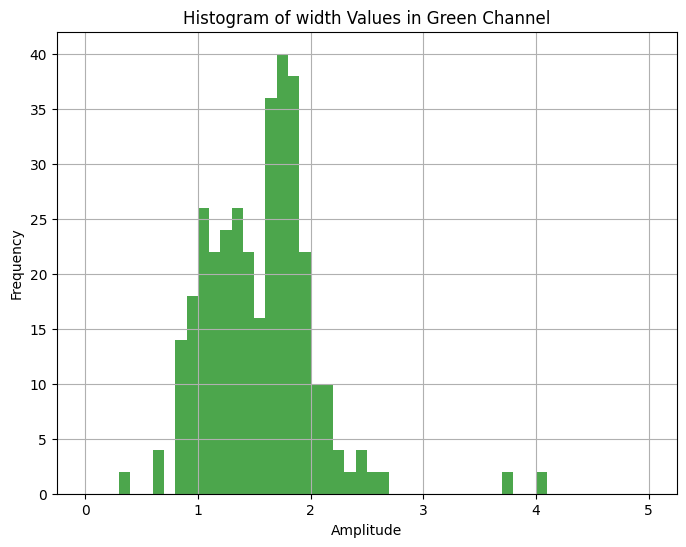

In [26]:
import matplotlib.pyplot as plt

# Plot histogram of amplitude values in green channel
plt.figure(figsize=(8, 6))
plt.hist(width_g, bins=50, range=(0,5), color='green', alpha=0.7)
plt.title('Histogram of width Values in Green Channel')
plt.xlabel('Width (Profiles)')
plt.ylabel('Frequency')
plt.grid(True)

plt.show()



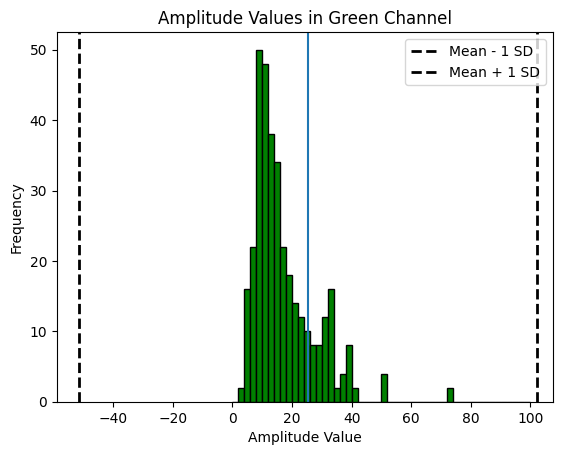

Mean Amplitude: 25.405263614993824
Standard Deviation: 76.74540132081812


In [72]:

mean_amplitude = np.mean(amp_val_a_g)
std_dev_amplitude = np.std(amp_val_a_g)

# Plot histogram
plt.hist(amp_val_a_g, bins=50, range=(0, 100), color='green', edgecolor='black')
plt.xlabel('Amplitude Value')
plt.ylabel('Frequency')
plt.title('Amplitude Values in Green Channel')

# Plot black dashed lines for one standard deviation above and below the mean
plt.axvline(x=mean_amplitude - std_dev_amplitude, color='black', linestyle='dashed', linewidth=2, label='Mean - 1 SD')
plt.axvline(x=mean_amplitude + std_dev_amplitude, color='black', linestyle='dashed', linewidth=2, label='Mean + 1 SD')
plt.axvline(x=mean_amplitude) # these values are silly looking if your only looking at a small region of the image, they get thighter in the big imagw

plt.legend()
plt.show()

# Print the mean and standard deviation
print(f'Mean Amplitude: {mean_amplitude}')
print(f'Standard Deviation: {std_dev_amplitude}')

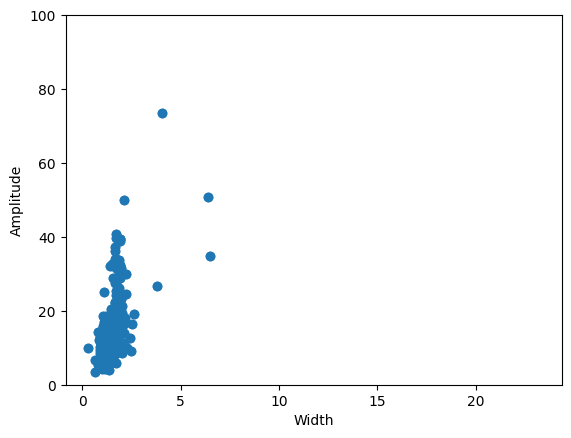

In [74]:
plt.scatter(width_g, amp_val_a_g, label='Amplitude vs Width Green')
plt.xlabel('Width')
plt.ylabel('Amplitude')

# Limiting the range of y-axis
plt.ylim(0, 100)

plt.show()


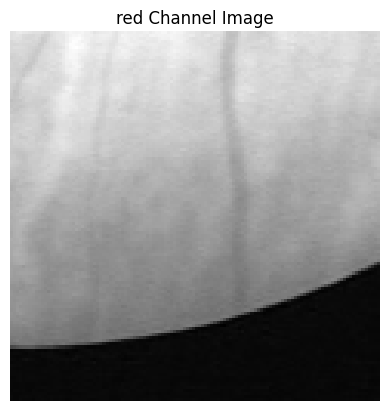

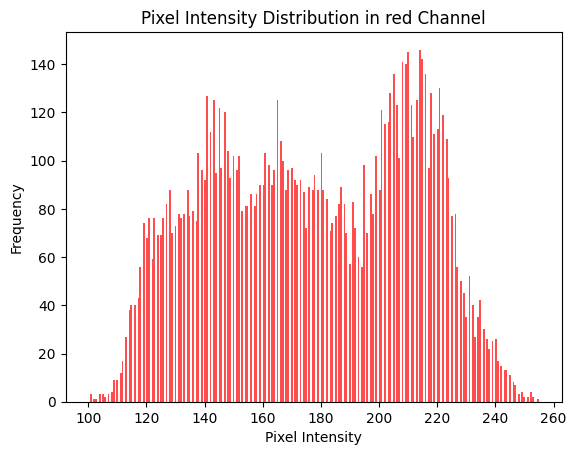

In [75]:
# Extract the red channel from the image
red_channel = raw[:, :, 0]  

# Plot the green channel image
plt.imshow(red_channel, cmap='gray') 
plt.title('red Channel Image')
plt.axis('off')  # Turn off axis
plt.show()
red_values = red_channel.flatten()

# Plot histogram
plt.hist(red_values, bins=256,range= (100,255), color='red', alpha=0.7)
plt.title('Pixel Intensity Distribution in red Channel')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()
#see the big difference between the definition of the two vessel types
#intensity distribution is confusing because the black section in the image which isnt to do with the retina

Red Channel Gaussian

In [112]:
# Initialize lists to store data
amp_val_a_r = []
start_coords_list_a_r = []
end_coords_list_a_r = []
vessel_points_a_r = []  # List to store vessel points
num_pairs = len(line_start_list)
width_r = []
r_squared_values_r = []

# Loop over each pair of coordinates
for i in range(num_pairs):
    start_coord = line_start_list[i]
    end_coord = line_end_list[i]

    # Create a copy of the original image
    raw_copy_1 = raw.copy()

    # Profile line for the current pair of coordinates on the red channel
    red_channel = raw_copy_1[:, :, 0]  
    pl_r = profile_line(red_channel, start_coord, end_coord, order=2, mode='constant', linewidth=1)

    # Plot the original profile line
    x_values_r = np.arange(len(pl_r))

    # Define the Gaussian model
    def gaussian(x, a, b, c, d, e):
        gs = np.exp(-((x - b)**2) / (2 * c**2))
        linearfunc = (d * x) + e
        return a * gs + linearfunc

    # Initial guess for Gaussian model parameters
    p0_r = [np.mean(pl_r), np.mean(x_values_r), 1, 1, 0]

    # Fit Gaussian model
    try:
        coeff_r, covariance = curve_fit(gaussian, x_values_r[:len(pl_r)], pl_r, p0=p0_r, maxfev=1000000)

        # Calculate R-squared value
        residuals_r = pl_r - gaussian(x_values_r[:len(pl_r)], *coeff_r)
        ss_res_r = np.sum(residuals_r**2)
        ss_tot_r = np.sum((pl_r - np.mean(pl_r))**2)
        r_squared_r = 1 - (ss_res_r / ss_tot_r)

        # Save the R-squared value
        r_squared_values_r.append(r_squared_r)

        # Check R-squared value, width condition, and amp value condition, then save data to the new lists
        if 0 <= np.abs(coeff_r[2]) <= 15 and r_squared_r > 0.90 and np.abs(coeff_r[0]) < 60:  #setting criteria, this can be easily changed depending on what data is being pooled
            amp_val_a_r.append(np.abs(coeff_r[0]))
            width_r.append(np.abs(coeff_r[2]))
            start_coords_list_a_r.append(start_coord)
            end_coords_list_a_r.append(end_coord)
            vessel_points_a_r.append(vessel_points_list)

    except Exception as e:
        print(f"Error occurred for pair {i}: {e}")



In [82]:
print(len(width_r))

102


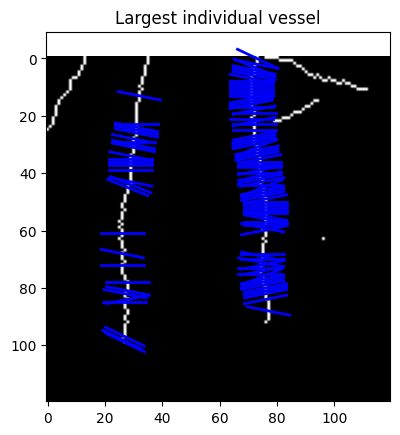

In [84]:
#the coordinates which passed the criteria
fig, ax = plt.subplots()

# Display the image
ax.imshow(skel, cmap='gray')
ax.set_title('Largest individual vessel')

# Loop over all start and end coordinates in the lists
for start_coord_r, end_coord_r in zip(start_coords_list_a_r, end_coords_list_a_r):
    # Plot a blue line for each pair of start and end coordinates
    ax.plot([start_coord_r[1], end_coord_r[1]],
            [start_coord_r[0], end_coord_r[0]],
            color='b', linestyle='-', linewidth=2)
# Show the plot
plt.show()




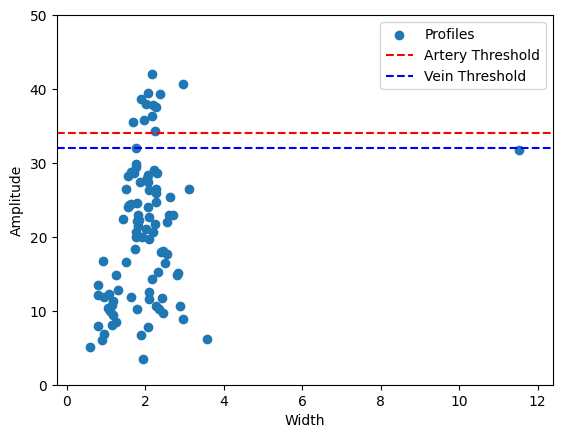

In [108]:
# Plotting
plt.scatter(width_r, amp_val_a_r, label='Profiles')
plt.xlabel('Width')
plt.ylabel('Amplitude')
plt.ylim(0,50)
# Draw a red line at y = 30.6
plt.axhline(y=34, color='red', linestyle='--', label='Artery Threshold')

# Draw a blue line at y = 32
plt.axhline(y=32, color='blue', linestyle='--', label='Vein Threshold')

plt.legend()
plt.show()

95% Confidence Interval: (0.5746377506175622, 3.8058673929514235)
2.1902525717844927


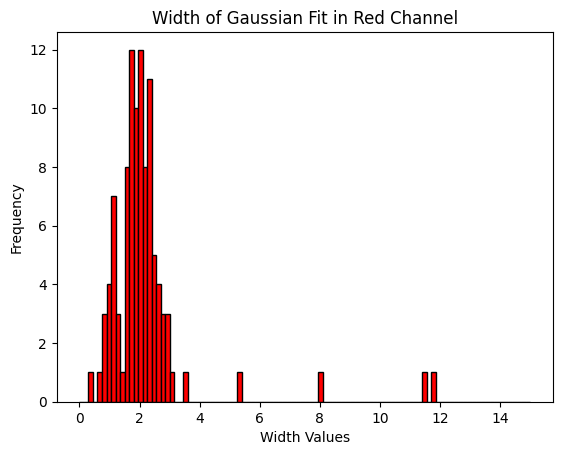

In [109]:
# Plot histogram
mean_width = []
std_dev_width = []
sample_size = []
standard_error =[]
confidence_level = 0.95
z_score = 1.96
margin_of_error = []

lower_limit_3sd = []
upper_limit_3sd =[]


mean_width = np.mean(width_r)
std_dev_width = np.std(width_r)
sample_size = len(width_r)
standard_error = std_dev_width / np.sqrt(sample_size)
confidence_level = 0.95
z_score = 1.96
margin_of_error = z_score * standard_error

lower_limit_3sd = mean_width - 1 * std_dev_width
upper_limit_3sd = mean_width + 1 * std_dev_width  

print(f'95% Confidence Interval: ({lower_limit_3sd}, {upper_limit_3sd})')
print(mean_width)
plt.hist(width_r, bins=100, range=(0, 15), color='red', edgecolor='black')
#plt.axvline(x=lower_limit_3sd, color='Black', linestyle='dashed', linewidth=2, label=f'Lower Limit')
#plt.axvline(x=upper_limit_3sd, color='black', linestyle='dashed', linewidth=2, label=f'Upper Limit')
plt.xlabel('Width Values')
plt.ylabel('Frequency')
plt.title('Width of Gaussian Fit in Red Channel')
#plt.legend()
plt.show()

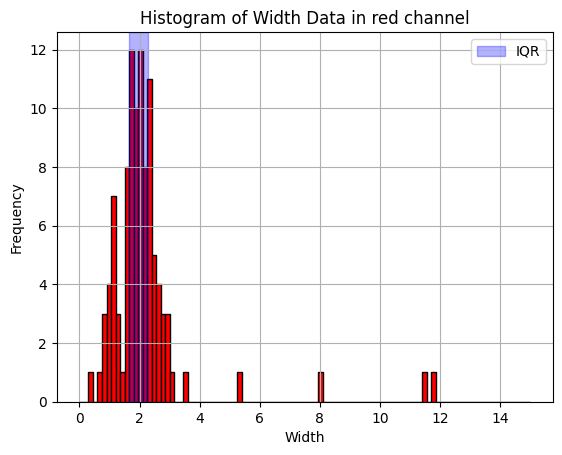

In [98]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate quartiles
Q1 = np.percentile(width_r, 25)
Q3 = np.percentile(width_r, 75)
IQR = Q3 - Q1

# Plot histogram
plt.hist(width_r, bins=100, range=(0, 15), color='red', edgecolor='black')
plt.title('Histogram of Width Data in red channel')
plt.xlabel('Width')
plt.ylabel('Frequency')
plt.grid(True)  # Add grid lines for better readability

# Overlay IQR
plt.axvspan(Q1, Q3, color='blue', alpha=0.3, label='IQR')

# Add legend
plt.legend()

plt.show()


In [100]:
from scipy.stats import skew

# Convert list to NumPy array
data_skewed_right = np.array(width_r)
skewness = skew(data_skewed_right)
print("Skewness coefficient:", skewness)
# A positive value indicates right skew

# Calculate mean, median, and mode
mean = np.mean(data_skewed_right)
median = np.median(data_skewed_right)
mode = np.argmax(np.bincount(data_skewed_right.astype(int)))

print("Mean:", mean)
print("Median:", median)
print("Mode:", mode)

# Compare mean, median, and mode to identify skewness
if mean > median > mode:
    print("The distribution is right-skewed.")
elif mode > median > mean:
    print("The distribution is left-skewed.")
else:
    print("The distribution is approximately symmetric.")


Skewness coefficient: 4.419589287024874
Mean: 2.1902525717844927
Median: 2.0012186580714553
Mode: 2
The distribution is right-skewed.


Mean Amplitude: 20.727450730549176
Standard Deviation: 9.653754408508448


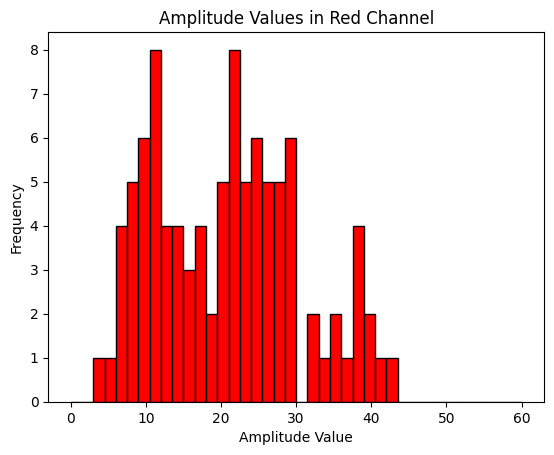

In [113]:
# Assuming amp_val_a_r is your data
mean_amplitude = np.mean(amp_val_a_r)
std_dev_amplitude = np.std(amp_val_a_r)

# Plot histogram
plt.hist(amp_val_a_r, bins=40, range=(0, 60), color='red', edgecolor='black')
plt.xlabel('Amplitude Value')
plt.ylabel('Frequency')
plt.title('Amplitude Values in Red Channel')

# Plot black dashed lines for one standard deviation above and below the mean
#plt.axvline(x=mean_amplitude - std_dev_amplitude, color='black', linestyle='dashed', linewidth=2, label='Mean - 1 SD')
#plt.axvline(x=mean_amplitude + std_dev_amplitude, color='black', linestyle='dashed', linewidth=2, label='Mean + 1 SD')
#plt.axvline(x=mean_amplitude)
#plt.legend()
#plt.show()

# Print the mean and standard deviation
print(f'Mean Amplitude: {mean_amplitude}')
print(f'Standard Deviation: {std_dev_amplitude}')
# Plot histogram


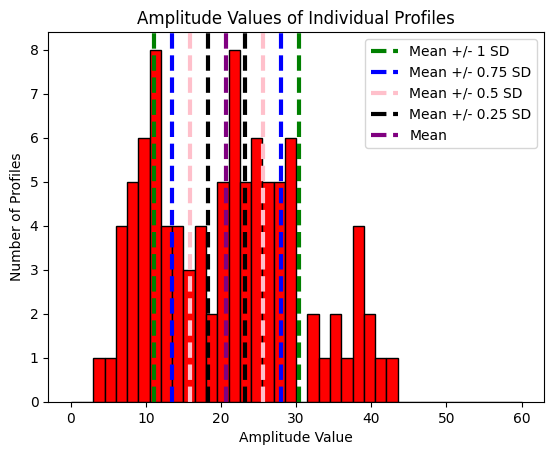

Standard Deviation: 9.653754408508448


In [114]:

plt.hist(amp_val_a_r, bins=40, range=(0, 60), color='red', edgecolor='black')
plt.xlabel('Amplitude Value')
plt.ylabel('Number of Profiles')
plt.title('Amplitude Values of Individual Profiles')

# Plot black dashed lines for one standard deviation above and below the mean
plt.axvline(x=mean_amplitude - std_dev_amplitude, color='green', linestyle='dashed', linewidth=3, label='Mean +/- 1 SD')
plt.axvline(x=mean_amplitude + std_dev_amplitude, color='green', linestyle='dashed', linewidth=3)# label='Mean + 1 SD')
plt.axvline(x=mean_amplitude - 3*(std_dev_amplitude)/4, color='blue', linestyle='dashed', linewidth=3, label='Mean +/- 0.75 SD')
plt.axvline(x=mean_amplitude + 3*(std_dev_amplitude)/4, color='blue', linestyle='dashed', linewidth=3 )#label='Mean + 0.75 SD')
plt.axvline(x=mean_amplitude - (std_dev_amplitude)/2, color='pink', linestyle='dashed', linewidth=3, label='Mean +/- 0.5 SD')
plt.axvline(x=mean_amplitude + (std_dev_amplitude)/2, color='pink', linestyle='dashed', linewidth=3)#, label='Mean + 0.5 SD')
plt.axvline(x=mean_amplitude - (std_dev_amplitude)/4, color='black', linestyle='dashed', linewidth=3, label='Mean +/- 0.25 SD')
plt.axvline(x=mean_amplitude + (std_dev_amplitude)/4, color='black', linestyle='dashed', linewidth=3)#, label='Mean + 0.25 SD')
plt.axvline(x=mean_amplitude, color='purple', linestyle='dashed', linewidth=3, label='Mean')

# Add arrows across the colors
plt.annotate('',
             xy=(mean_amplitude - std_dev_amplitude, 50),
           #  xytext=(mean_amplitude + std_dev_amplitude, 50),
             arrowprops=dict(arrowstyle='<->', color='green', linewidth=2))

plt.annotate('',
             xy=(mean_amplitude - 3*(std_dev_amplitude)/4, 45),
           #  xytext=(mean_amplitude + 3*(std_dev_amplitude)/4, 45),
             arrowprops=dict(arrowstyle='<->', color='blue', linewidth=2))

plt.annotate('',
             xy=(mean_amplitude - (std_dev_amplitude)/2, 40),
           #  xytext=(mean_amplitude + (std_dev_amplitude)/2, 40),
             arrowprops=dict(arrowstyle='<->', color='pink', linewidth=2))

plt.annotate('',
             xy=(mean_amplitude - (std_dev_amplitude)/4, 35),
            # xytext=(mean_amplitude + (std_dev_amplitude)/4, 35),
             arrowprops=dict(arrowstyle='<->', color='black', linewidth=2))

# Display the plot
plt.legend()
plt.show()

# Print the standard deviation
print(f'Standard Deviation: {std_dev_amplitude}')


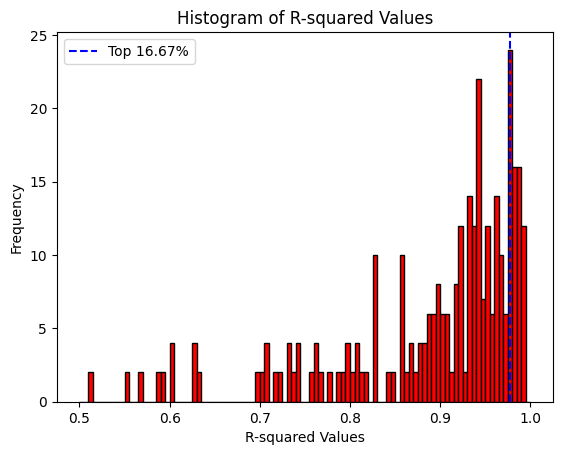

In [43]:
plt.hist(r_squared_values_r, bins=100, range=(0.5, 1), color='red', edgecolor='black')
plt.xlabel('R-squared Values')
plt.ylabel('Frequency')
plt.title('Histogram of R-squared Values')

# Calculate the 83.33th percentile (top 16.67%)
top_1667_percentile = np.percentile(r_squared_values_r, 83.33)

# Add a vertical line at the percentile
plt.axvline(x=top_1667_percentile, color='blue', linestyle='--', label='Top 16.67%')


# Add legend
plt.legend()

plt.show()


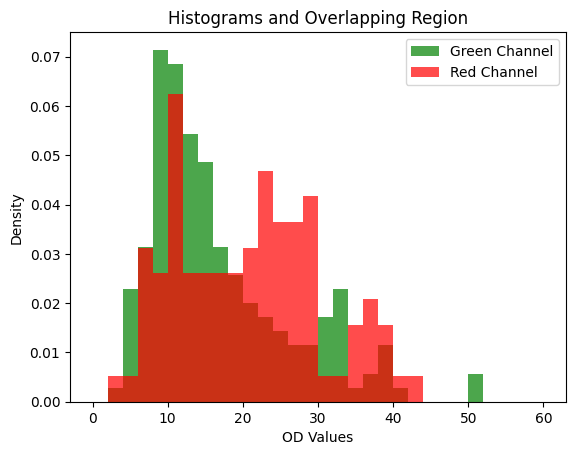

In [115]:
# Plot individual histograms
plt.hist(amp_val_a_g, bins=30, range=(0,60 ), color='green', alpha=0.7, label='Green Channel', density=True)
plt.hist(amp_val_a_r, bins=30, range=(0, 60), color='red', alpha=0.7, label='Red Channel', density=True)

# Calculate overlapping region
bin_edges = np.linspace(0, 100, 20) 
overlapping_counts, _ = np.histogram(amp_val_a_r, bins=bin_edges, density=True)

# Set labels and title
plt.xlabel('OD Values')
plt.ylabel('Density')
plt.title('Histograms and Overlapping Region')
plt.legend()
plt.show()


In [116]:
print(mean_amplitude)

20.727450730549176


In [117]:
print(std_dev_amplitude)

9.653754408508448


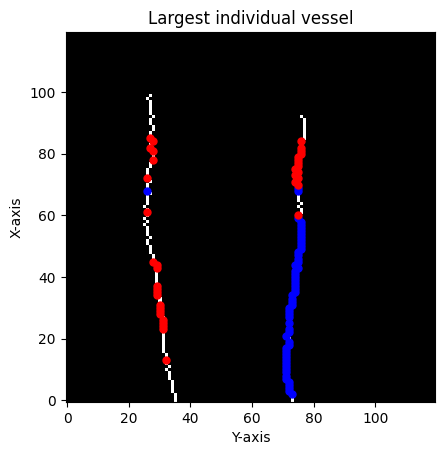

Number of Red Coordinates: 38
Number of Blue Coordinates: 58


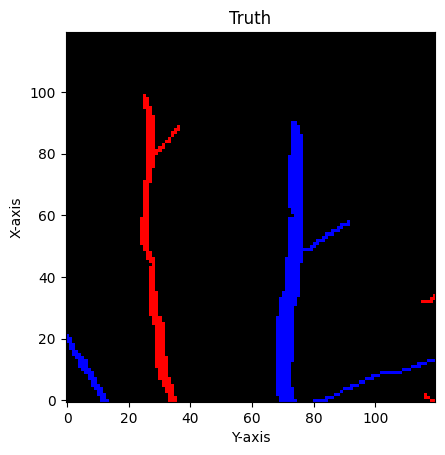

In [126]:
# Create a figure and axis
fig, ax = plt.subplots()
ax.imshow(all_combined_vessels_image, cmap='gray')
ax.set_title('Largest individual vessel')

# Initialize counters for red and blue coordinates
red_coords_count = 0
blue_coords_count = 0

# Identify and set color and size of pixels for aligned points
for i in range(len(start_coords_list_a_r)):
    start_coord_final = start_coords_list_a_r[i]
    end_coord_final = end_coords_list_a_r[i]
    
    # Get value for the current line
    current_amp = amp_val_a_r[i]
    
    # Determine the color and size based on the amp value
    marker_color = 'red' if 0 <= current_amp <= 17 else ('blue' if 17 <= current_amp <= 80 else 'none') # change the 17 to sd if using suitable range

    marker_size = 5 
 
    # Plot a small circle at the center of the line with the determined color and size
    center_x = int((start_coord_final[0] + end_coord_final[0]) / 2)
    center_y = int((start_coord_final[1] + end_coord_final[1]) / 2)
    
    # Ensure the calculated coordinates are within the image dimensions
    if 0 <= center_x < skel.shape[0] and 0 <= center_y < skel.shape[1]:
        ax.plot(center_y, center_x, 'o', markersize=marker_size, color=marker_color)
        
        # Count red and blue coordinates
        if marker_color == 'red':
            red_coords_count += 1
        elif marker_color == 'blue':
            blue_coords_count += 1

# Set labels and legend
ax.set_xlabel('Y-axis')
ax.set_ylabel('X-axis')
plt.gca().invert_yaxis()

plt.show()

# Print the number of red and blue coordinates
print(f'Number of Red Coordinates: {red_coords_count}')
print(f'Number of Blue Coordinates: {blue_coords_count}')

img_origin = '04_test 2.png'
img_origin_test= cv2.imread(img_origin)
img_test = cv2.cvtColor(img_origin_test, cv2.COLOR_BGR2RGB)

test_range= img_test[460:580,280:400] #[20:130,380:460]#[185:250,200:285]
fig, ax = plt.subplots()

# Show the image
ax.imshow(test_range)

# Set axis labels
ax.set_xlabel('Y-axis')
ax.set_ylabel('X-axis')
plt.gca().invert_yaxis()
# Set title
ax.set_title("Truth")

plt.show()


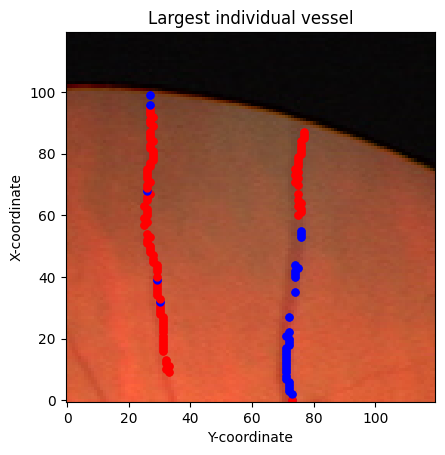

All Coordinates: [(9.0, 33.0), (10.0, 32.0), (11.0, 33.0), (12.0, 32.0), (13.0, 32.0), (14.0, 32.0), (15.0, 32.0), (16.0, 31.0), (17.0, 31.0), (18.0, 31.0), (19.0, 31.0), (20.0, 31.0), (21.0, 31.0), (22.0, 31.0), (23.0, 31.0), (24.0, 31.0), (25.0, 31.0), (26.0, 31.0), (27.0, 31.0), (28.0, 30.0), (29.0, 30.0), (30.0, 30.0), (31.0, 30.0), (32.0, 30.0), (33.0, 30.0), (34.0, 29.0), (35.0, 29.0), (36.0, 29.0), (37.0, 29.0), (38.0, 29.0), (39.0, 29.0), (40.0, 29.0), (41.0, 29.0), (42.0, 29.0), (43.0, 29.0), (44.0, 29.0), (45.0, 28.0), (46.0, 28.0), (47.0, 28.0), (48.0, 27.0), (49.0, 27.0), (50.0, 27.0), (51.0, 26.0), (52.0, 26.0), (53.0, 27.0), (54.0, 26.0), (55.0, 26.0), (56.0, 26.0), (57.0, 25.0), (58.0, 26.0), (59.0, 25.0), (60.0, 26.0), (61.0, 26.0), (62.0, 26.0), (63.0, 25.0), (64.0, 26.0), (65.0, 26.0), (66.0, 26.0), (67.0, 27.0), (68.0, 26.0), (69.0, 26.0), (70.0, 26.0), (71.0, 27.0), (72.0, 26.0), (73.0, 26.0), (74.0, 26.0), (75.0, 26.0), (76.0, 27.0), (77.0, 27.0), (78.0, 28.0), (79

In [50]:
# Lists to store coordinates and their corresponding color
all_coords = []
all_colors = []

# Loop through each pixel in the vessel
for i in range(len(start_coords_list_a_r)):
    start_coord_final = start_coords_list_a_r[i]
    end_coord_final = end_coords_list_a_r[i]
    
    # Get OD value for the current line
    current_od = amp_val_a_r[i]
    
  
    marker_color = 'red' if 0 <= current_od <= 17 else ('blue' if 25<= current_od <=200 else 'none')
    
    # Calculate the middle coordinates
    middle_coord = ((start_coord_final[0] + end_coord_final[0]) / 2, (start_coord_final[1] + end_coord_final[1]) / 2)
    
    # Store middle coordinates and their corresponding color in separate lists
    all_coords.append(middle_coord)
    all_colors.append(marker_color)

# Create a figure and axis
fig, ax = plt.subplots()

# Display the skeleton image
ax.imshow(raw, cmap='gray')
ax.set_title('Largest individual vessel')

# Plot the middle coordinates with the corresponding color
for coord, color in zip(all_coords, all_colors):
    center_x = int(coord[0])
    center_y = int(coord[1])
    
    # Ensure the calculated coordinates are within the image dimensions
    if 0 <= center_x < skel.shape[0] and 0 <= center_y < skel.shape[1]:
        ax.plot(center_y, center_x, 'o', markersize=5, color=color)

# Set labels and legend
ax.set_xlabel('Y-coordinate')
ax.set_ylabel('X-coordinate')
plt.gca().invert_yaxis()

plt.show()

# Print the lists of coordinates and colors
print("All Coordinates:", all_coords)
print("All Colors:", all_colors)


In [52]:
from collections import Counter
all_coords_with_color_and_vessel = []

# Create a dictionary mapping coordinates to colors
coord_color_mapping = dict(zip(all_coords, all_colors))

# Loop through each vessel in renamed_combined_vessels
for vessel_id, vessel_coords in renamed_combined_vessels.items():
    # Extract colors for the current vessel excluding 'white'
    vessel_colors_for_vessel = [coord_color_mapping.get(coord) for coord in vessel_coords if coord_color_mapping.get(coord) in ('red', 'blue')]

    # Find the majority color among 'red' and 'blue'
    if vessel_colors_for_vessel:
        majority_color = Counter(vessel_colors_for_vessel).most_common(1)[0][0]
    else:
        # Default to 'white' if the list is empty
        majority_color = 'white'

    # Append each coordinate with its color and vessel to the new variable
    all_coords_with_color_and_vessel.extend([(coord, majority_color, vessel_id) for coord in vessel_coords])


color_of_whole_vessel = []

# Loop through each vessel in renamed_combined_vessels
for vessel_id, vessel_coords in renamed_combined_vessels.items():
    # Extract colors for the current vessel excluding 'white'
    vessel_colors_for_vessel = [coord_color_mapping.get(coord) for coord in vessel_coords if coord_color_mapping.get(coord) in ('red', 'blue')]

    # Find the majority color among 'red' and 'blue'
    if vessel_colors_for_vessel:
        majority_color = Counter(vessel_colors_for_vessel).most_common(1)[0][0]
    else:
        # Default to 'white' if the list is empty
        majority_color = 'white'

    # Append the majority color to the color_of_whole_vessel list
    color_of_whole_vessel.append((vessel_id, majority_color))

# Now color_of_whole_vessel contains the majority color for each vessel (excluding 'white')
print("Color of Whole Vessel (excluding white):", color_of_whole_vessel)



Color of Whole Vessel (excluding white): [(0, 'red'), (1, 'blue')]


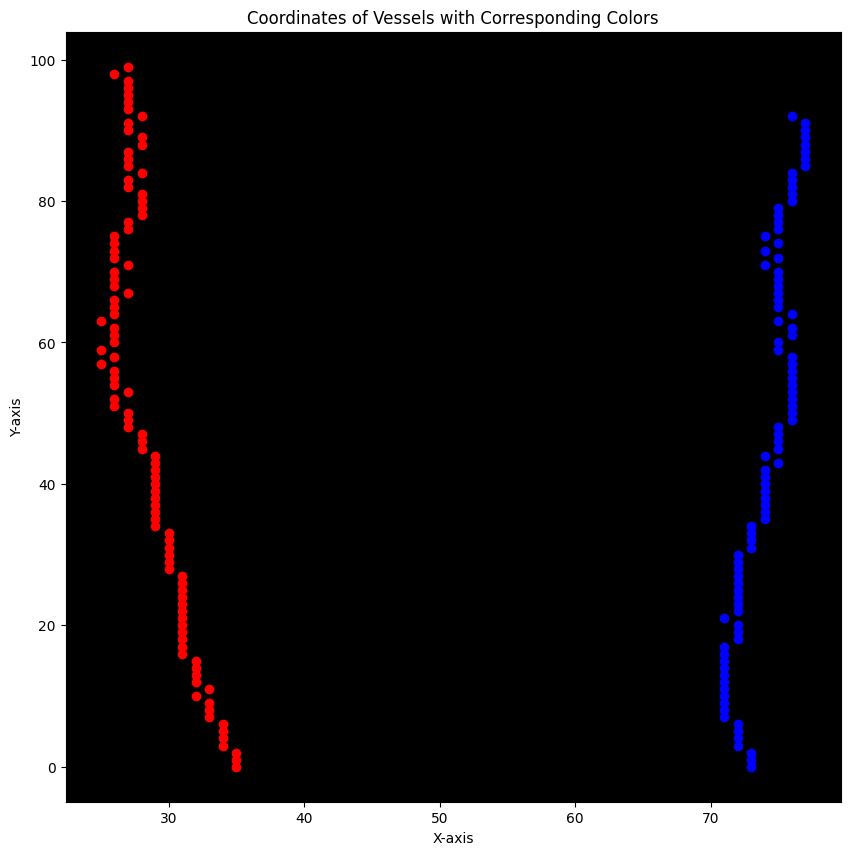

In [53]:
color_mapping = {'red': 'red', 'blue': 'blue', 'none': 'white'} 

# Create a blank plot
plt.figure(figsize=(10, 10))
plt.axes().set_facecolor('black')

# Loop through each vessel in color_of_whole_vessel
for vessel_id, color_str in color_of_whole_vessel:
    # Get the coordinates for the current vessel
    vessel_coords = np.array(renamed_combined_vessels[vessel_id])  # Convert to NumPy array

    # Get the corresponding color
    color = color_mapping.get(color_str, 'white')  
    # Scatter plot the coordinates with the specified color
    plt.scatter(vessel_coords[:, 1], vessel_coords[:, 0], color=color, label=f'Vessel {vessel_id}')

plt.title('Coordinates of Vessels with Corresponding Colors')
plt.show()
